In [1]:
import sys
sys.path.append("/src")

In [2]:
from collections import namedtuple
import time 

import matplotlib.pyplot as plt
import numpy as np
import torch
# For getting VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image
from tqdm import tqdm_notebook

from transformer_net import TransformerNet
from utils import gram_matrix, recover_image, tensor_normalizer

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
SEED = 1080
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    kwargs = {}

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 4
DATASET = "/data/train/"
transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.ToTensor(),
                                tensor_normalizer()])
# http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
train_dataset = datasets.ImageFolder(DATASET, transform)
# http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [6]:
LossOutput = namedtuple("LossOutput", ["relu1_2", "relu2_2", "relu3_3", "relu4_3"])

# https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/3
class LossNetwork(torch.nn.Module):
    def __init__(self, vgg_model):
        super(LossNetwork, self).__init__()
        self.vgg_layers = vgg_model.features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
    
    def forward(self, x):
        output = {}
        for name, module in self.vgg_layers._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                output[self.layer_name_mapping[name]] = x
        return LossOutput(**output)

In [7]:
vgg_model = vgg.vgg16(pretrained=True)
if torch.cuda.is_available():
    vgg_model.cuda()
loss_network = LossNetwork(vgg_model)
loss_network.eval()
del vgg_model

In [8]:
STYLE_IMAGE = "/data/style/picasso_2.jpg"
style_img = Image.open(STYLE_IMAGE).convert('RGB')
style_img_tensor = transforms.Compose([
    transforms.ToTensor(),
    tensor_normalizer()]
)(style_img).unsqueeze(0)
# assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
if torch.cuda.is_available():
    style_img_tensor = style_img_tensor.cuda()

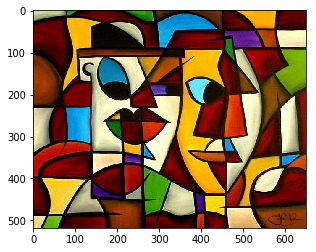

In [9]:
plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

In [10]:
# http://pytorch.org/docs/master/notes/autograd.html#volatile
style_loss_features = loss_network(Variable(style_img_tensor, volatile=True))
gram_style = [Variable(gram_matrix(y).data, requires_grad=False) for y in style_loss_features]

In [11]:
style_loss_features._fields

('relu1_2', 'relu2_2', 'relu3_3', 'relu4_3')

In [12]:
np.mean(gram_style[3].data.cpu().numpy())

0.00033448197

In [13]:
np.mean(style_loss_features[3].data.cpu().numpy())

0.37621668

In [14]:
gram_style[0].numel()

4096

In [15]:
def save_debug_image(tensor_orig, tensor_transformed, filename):
    assert tensor_orig.size() == tensor_transformed.size()
    result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
    orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
    new_im = Image.new('RGB', (result.size[0] * 2 + 5, result.size[1]))
    new_im.paste(orig, (0,0))
    new_im.paste(result, (result.size[0] + 5,0))
    new_im.save(filename)

In [16]:
%mkdir -p debug

In [17]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
# l1_loss = torch.nn.L1Loss()
if torch.cuda.is_available():
    transformer.cuda()

In [18]:
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 1e5
LOG_INTERVAL = 200
REGULARIZATION = 1e-7

LR = 1e-3
optimizer = Adam(transformer.parameters(), LR)
transformer.train()
for epoch in range(2):
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.
    count = 0
    for batch_id, (x, _) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
        n_batch = len(x)
        count += n_batch
        optimizer.zero_grad()
        x = Variable(x)
        if torch.cuda.is_available():
            x = x.cuda()

        y = transformer(x)
        xc = Variable(x.data, volatile=True)

        features_y = loss_network(y)
        features_xc = loss_network(xc)

        f_xc_c = Variable(features_xc[1].data, requires_grad=False)

        content_loss = CONTENT_WEIGHT * mse_loss(features_y[1], f_xc_c)

        reg_loss = REGULARIZATION * (
            torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
            torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        style_loss = 0.
        for m in range(len(features_y)):
            gram_s = gram_style[m]
            gram_y = gram_matrix(features_y[m])
            style_loss += STYLE_WEIGHT * mse_loss(gram_y, gram_s.expand_as(gram_y))

        total_loss = content_loss + style_loss + reg_loss
        total_loss.backward()
        optimizer.step()

        agg_content_loss += content_loss.data[0]
        agg_style_loss += style_loss.data[0]
        agg_reg_loss += reg_loss.data[0]

        if (batch_id + 1) % LOG_INTERVAL == 0:
            mesg = "{} [{}/{}] content: {:.6f}  style: {:.6f}  reg: {:.6f}  total: {:.6f}".format(
                        time.ctime(), count, len(train_dataset),
                        agg_content_loss / LOG_INTERVAL,
                        agg_style_loss / LOG_INTERVAL,
                        agg_reg_loss / LOG_INTERVAL,
                        (agg_content_loss + agg_style_loss + agg_reg_loss) / LOG_INTERVAL
                    )
            print(mesg)
            agg_content_loss = 0
            agg_style_loss = 0
            agg_reg_loss = 0
            transformer.eval()
            y = transformer(x)
            save_debug_image(x.data, y.data, "debug/{}_{}.png".format(epoch, count))
            transformer.train()

HBox(children=(IntProgress(value=0, max=20696), HTML(value='')))

RuntimeError: The expanded size of the tensor (256) must match the existing size (32) at non-singleton dimension 2. at /pytorch/torch/lib/THC/generic/THCTensor.c:340